In [ ]:
from bs4 import BeautifulSoup as bs
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import numpy as np
import math
import requests
import smtplib
import ssl
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.application import MIMEApplication
from google.colab import userdata
import os

In [ ]:
def get_months(month,year):
  start=datetime(year,month,1)
  dates=[]
  for i in range(24):
    cur=start - timedelta(days=30*i)
    month_name=datetime.strptime(str(cur.month),"%m").strftime("%b")
    dates.append(f"{month_name}-{cur.year % 100}")
  return dates

In [ ]:
def usd_per_ton(eu):
  try:
    resp=requests.get('https://www.xe.com/currencyconverter/convert/?Amount=1&From=EUR&To=USD')
    res=bs(resp.text,'html.parser')
    rate=float(res.find('p',class_='sc-295edd9f-1 jqMUXt').text.split(' ')[0])
    price= eu*rate*10
    return round(price,2)
  except Exception as e:
    print(e)
    return 0

In [ ]:
  #Calculate last 24 months
  cur_year=datetime.now().year
  cur_month=datetime.now().month
  dates=get_months(cur_month,cur_year)
  dates=dates[::-1]

In [ ]:
def getdet():
  #Define URLs
  urls=['https://www.westmetall.com/en/markdaten.php?action=averages&field=LME_Al_cash','https://www.westmetall.com/en/markdaten.php?action=averages&field=LME_Zn_cash','https://www.westmetall.com/en/markdaten.php?action=averages&field=LME_Cu_cash']

  #Fetch the data
  for url in urls:
    try:
      resp=requests.get(url)
      res=bs(resp.text,'html.parser')
      rows=res.find_all('tr',class_=False)
      metal_name=res.find('h2',class_=False)
      data=[]
      for row in rows:
          cells=row.find_all('td')
          if len(cells)>1 and len(data)<24:
              data.append(cells[1].text.strip())
          else:
              break
      data=data[::-1]
      for i in range(len(data)):
        if ',' in data[i]:
          data[i] = float(data[i].replace(',', ''))
    except Exception as e:
      print('Fetch Error!')
      print(e)

    #Plot the graphs
    try:
      plt.figure(figsize=(20, 10))
      plt.plot(dates, data, marker='o', linestyle='-' ,color ='orange')
      plt.title('LME - {} PRICE TREND - 24 MONTHS'.format(metal_name.text.upper()), weight='bold')
      plt.xlabel('Month & year')
      plt.ylabel('Values in USD/TON')
      plt.ylim(0,math.ceil(max(data)/1000)*1000 + 1000)
      plt.grid(axis='y',linestyle='-',color='gray',linewidth=0.6)
      for i,txt in enumerate(data):
          plt.annotate(txt,(dates[i],data[i]),textcoords="offset points",xytext=(0,10),ha='center')
      if(data[23]<data[22]):
        plt.annotate('', xy=(1, 0.6), xycoords='axes fraction', xytext=(1, 0.8),arrowprops=dict(facecolor='green', shrink=0.25, width=5, headwidth=10))
      else:
        plt.annotate('', xy=(1, 1), xycoords='axes fraction', xytext=(1, 0.8),arrowprops=dict(facecolor='red', shrink=0.25, width=5, headwidth=12))
      plt.savefig(f'{metal_name.text}.png')
    except Exception as e:
      print('Plot Error!')
      print(e)


In [ ]:
def getbrass():
  #Fetch the data
  try:
    resp=requests.get('https://www.westmetall.com/en/markdaten.php?action=averages&field=MB_MS_58_1')
    res=bs(resp.text,'html.parser')
    rows=res.find_all('tr',class_=False)
    metal_name=res.find('h2',class_=False)
    data=[]
    for row in rows:
        cells=row.find_all('td')
        if len(cells)>1 and len(data)<24:
            data.append(usd_per_ton(float(cells[1].text.strip())))
        else:
            break
    data=data[::-1]
  except Exception as e:
    print('Fetch Error 2!')
    print(e)

  #Plot the graphs
  try:
    plt.figure(figsize=(25, 15))
    plt.plot(dates, data, marker='o', linestyle='-' ,color ='orange')
    plt.title('LME - {} PRICE TREND - 24 MONTHS'.format(metal_name.text.split(" ")[0].upper()), weight='bold')
    plt.xlabel('Month & year')
    plt.ylabel('Values in USD/TON')
    plt.ylim(0,math.ceil(max(data)/1000)*1000 + 1000)
    plt.grid(axis='y',linestyle='-',color='gray',linewidth=0.6)
    for i,txt in enumerate(data):
        plt.annotate(txt,(dates[i],data[i]),textcoords="offset points",xytext=(0,10),ha='center')
    if(data[23]<data[22]):
      plt.annotate('', xy=(1, 0.6), xycoords='axes fraction', xytext=(1, 0.8),arrowprops=dict(facecolor='green', shrink=0.25, width=5, headwidth=10))
    else:
      plt.annotate('', xy=(1, 1), xycoords='axes fraction', xytext=(1, 0.8),arrowprops=dict(facecolor='red', shrink=0.25, width=5, headwidth=12))
    plt.savefig(f'{metal_name.text.split(" ")[0]}.png')
  except Exception as e:
    print('Plot Error 2!')
    print(e)

In [ ]:
def sendmail():
    subject = "Metal Price Trends"
    sender_email = "sander@gmail.com"
    recipient_email = ['receiver1@gmail.com', 'receiver2@gmail.com']
    sender_password = 'password'
    smtp_server = 'smtp.gmail.com'
    folder_path = '/content'
    smtp_port = 465

    # Create the root message
    message = MIMEMultipart('related')
    message['Subject'] = subject
    message['From'] = sender_email
    message['To'] = ','.join(recipient_email)

    # Create the HTML body with image placeholders
    body_html = """\
    <html>
      <body>
        <p>Graph of some metal price trends are attached below:</p>
    """

    image_list = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            with open(file_path, 'rb') as attachment:
                img_data = attachment.read()
                img_cid = filename.replace(".", "_")
                body_html += f'<img src="cid:{img_cid}" width="600" height="400"><br>'
                image_list.append((img_data, img_cid, filename))
                os.remove(file_path)

    body_html += """\
      </body>
    </html>
    """

    # Attach the HTML part
    body_part = MIMEText(body_html, 'html')
    message.attach(body_part)

    # Attach the images
    for img_data, img_cid, filename in image_list:
        img_part = MIMEImage(img_data, name=filename)
        img_part.add_header('Content-ID', f'<{img_cid}>')
        img_part.add_header('Content-Disposition', 'inline', filename=filename)
        message.attach(img_part)

    # Send the email
    try:
        with smtplib.SMTP_SSL(smtp_server, smtp_port) as server:
            server.login(sender_email, sender_password)
            server.sendmail(sender_email, recipient_email, message.as_string())
            print("Mail sent successfully!")
    except Exception as e:
        print("Mail not sent.")
        print(e)
    finally:
        print("Process completed!")
        return




Mail not sent.
(535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials d2e1a72fcca58-70677465799sm1983302b3a.62 - gsmtp')
Process completed!


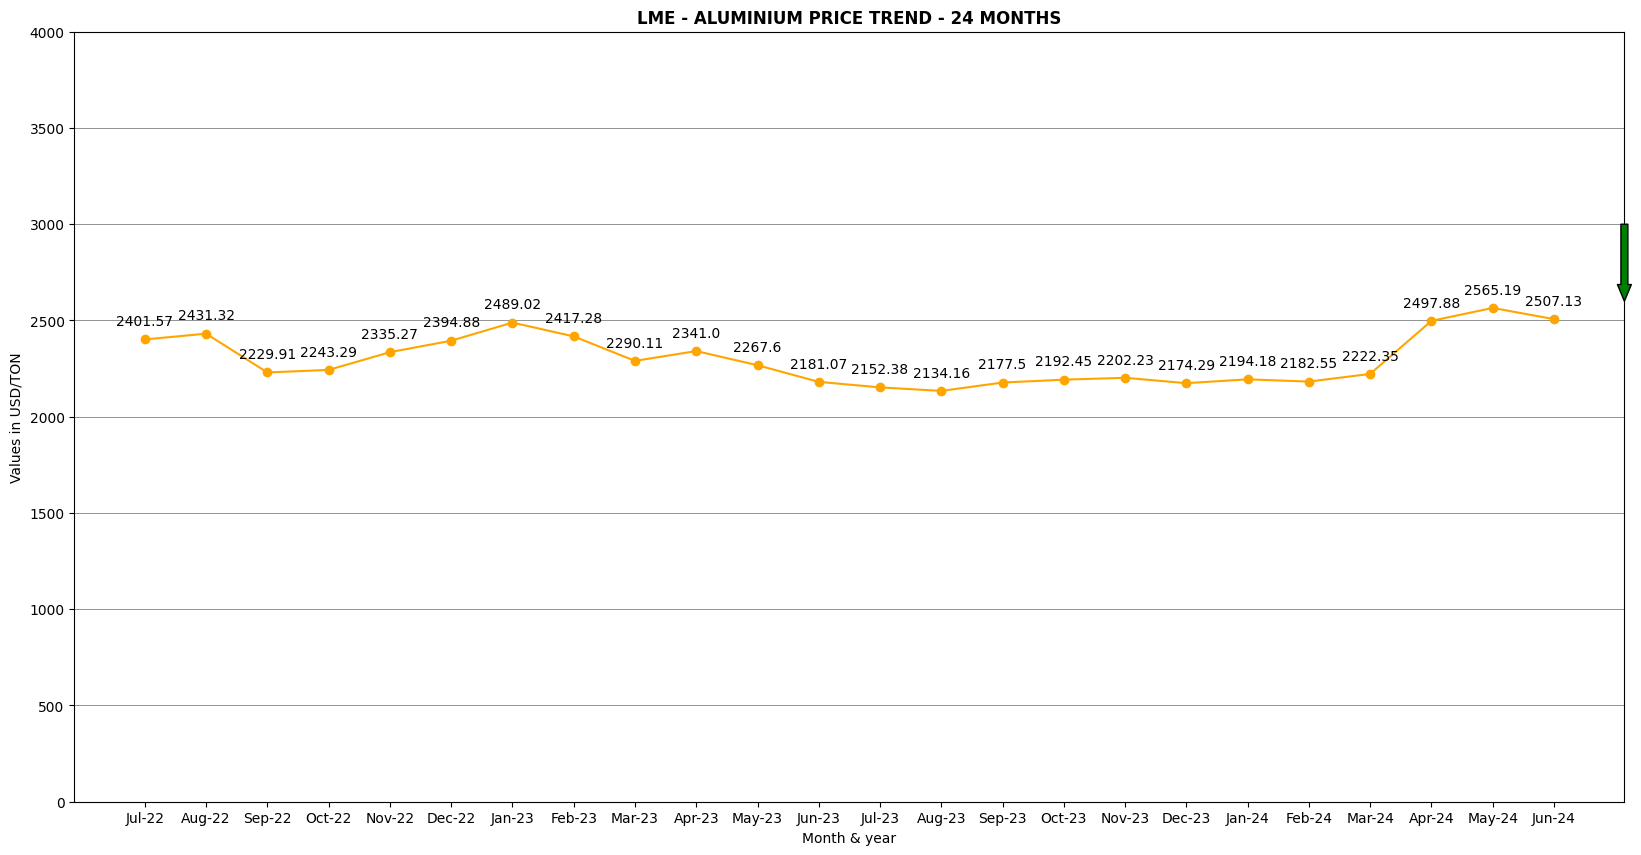

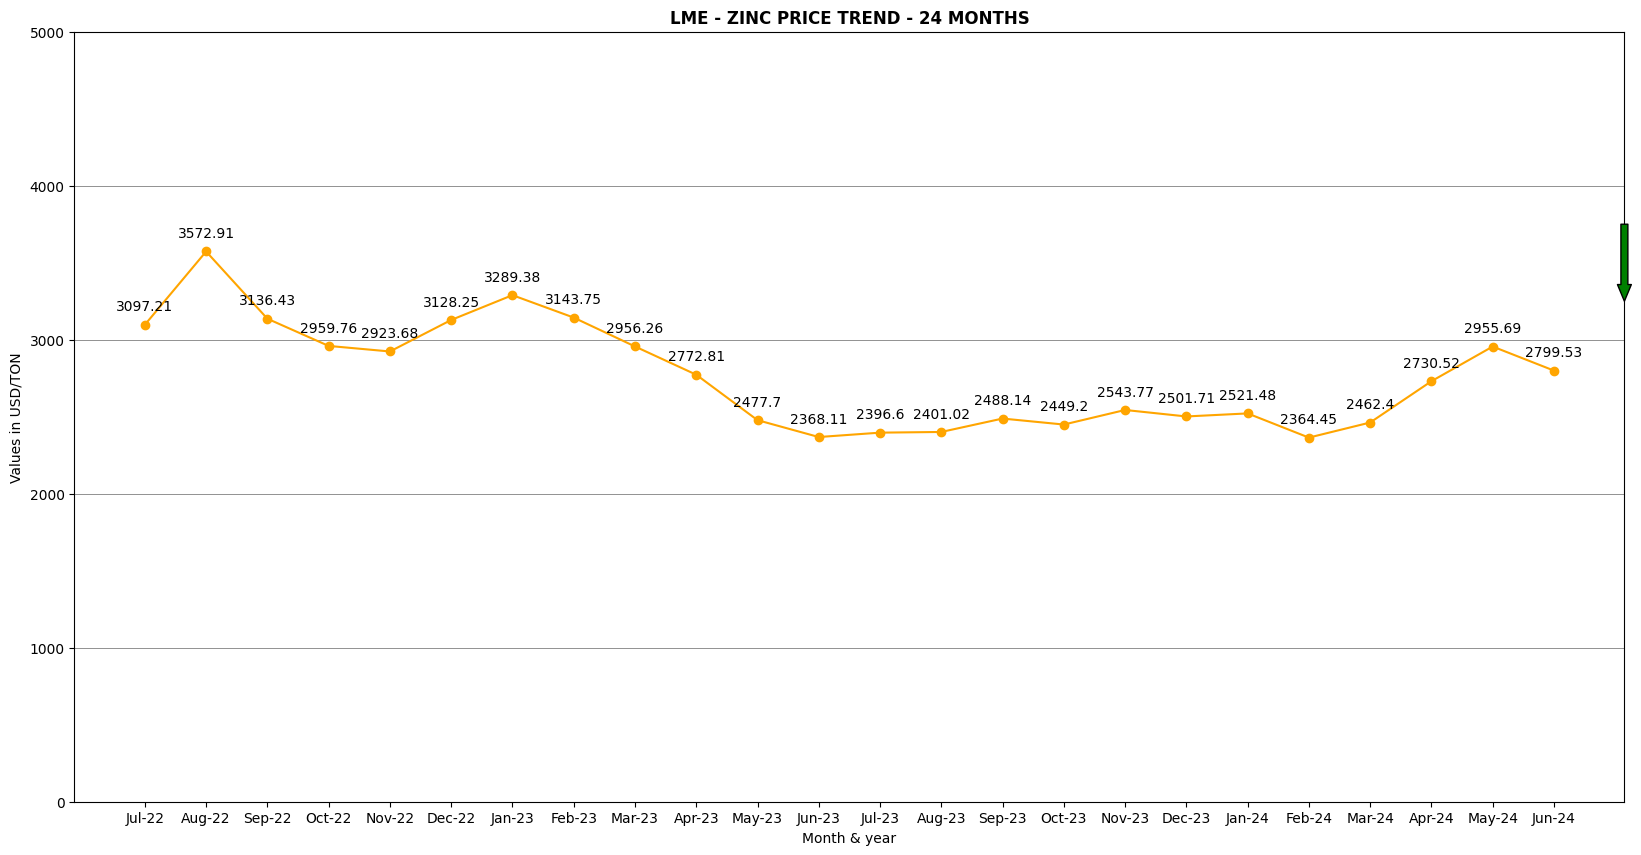

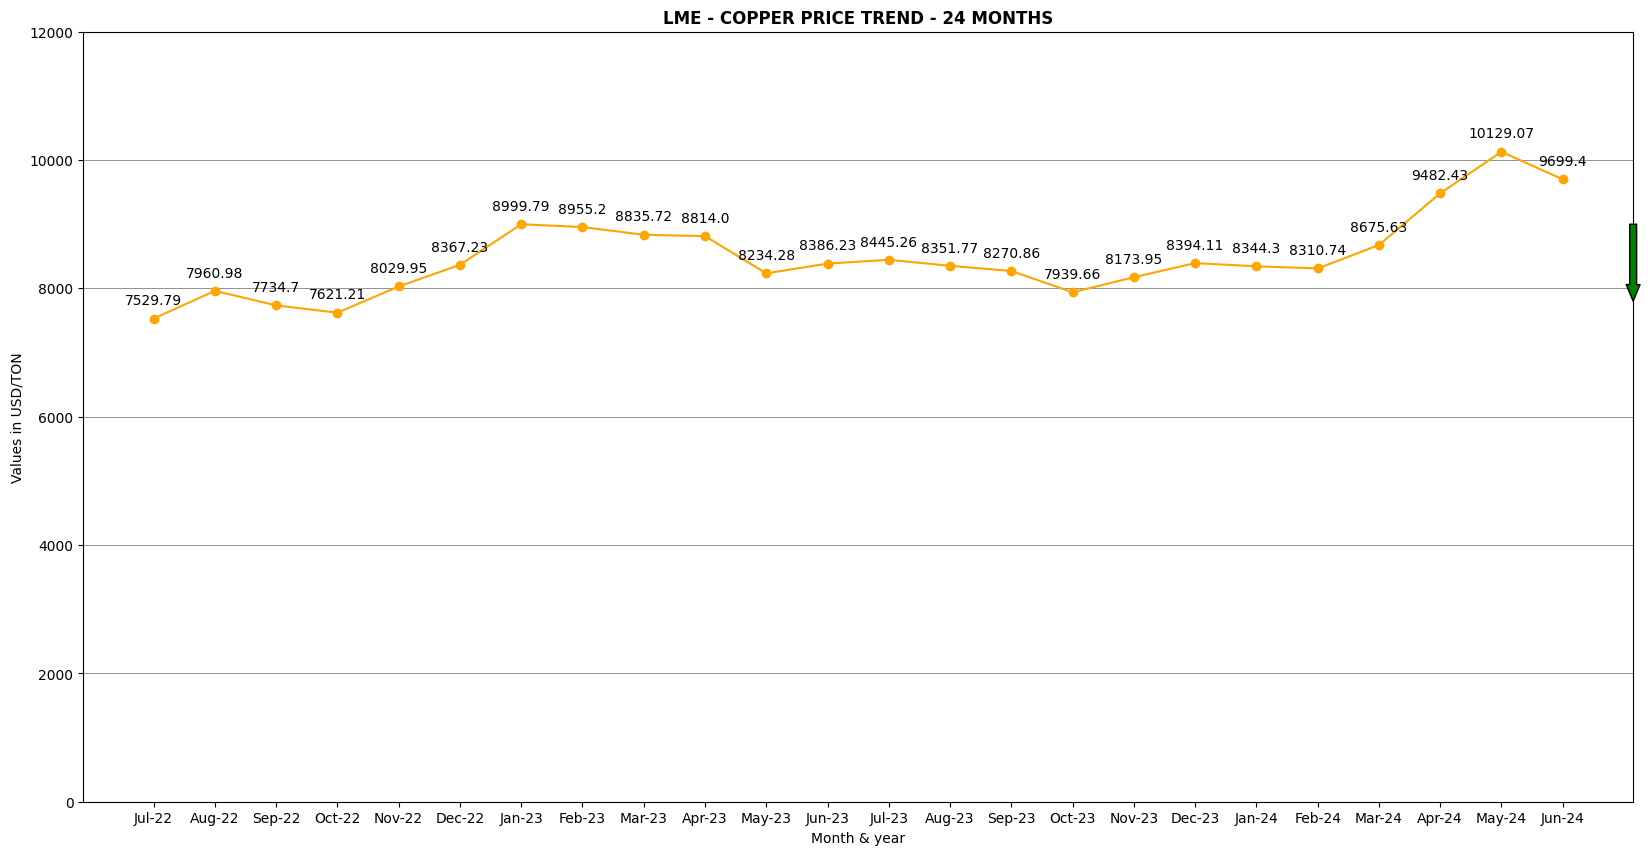

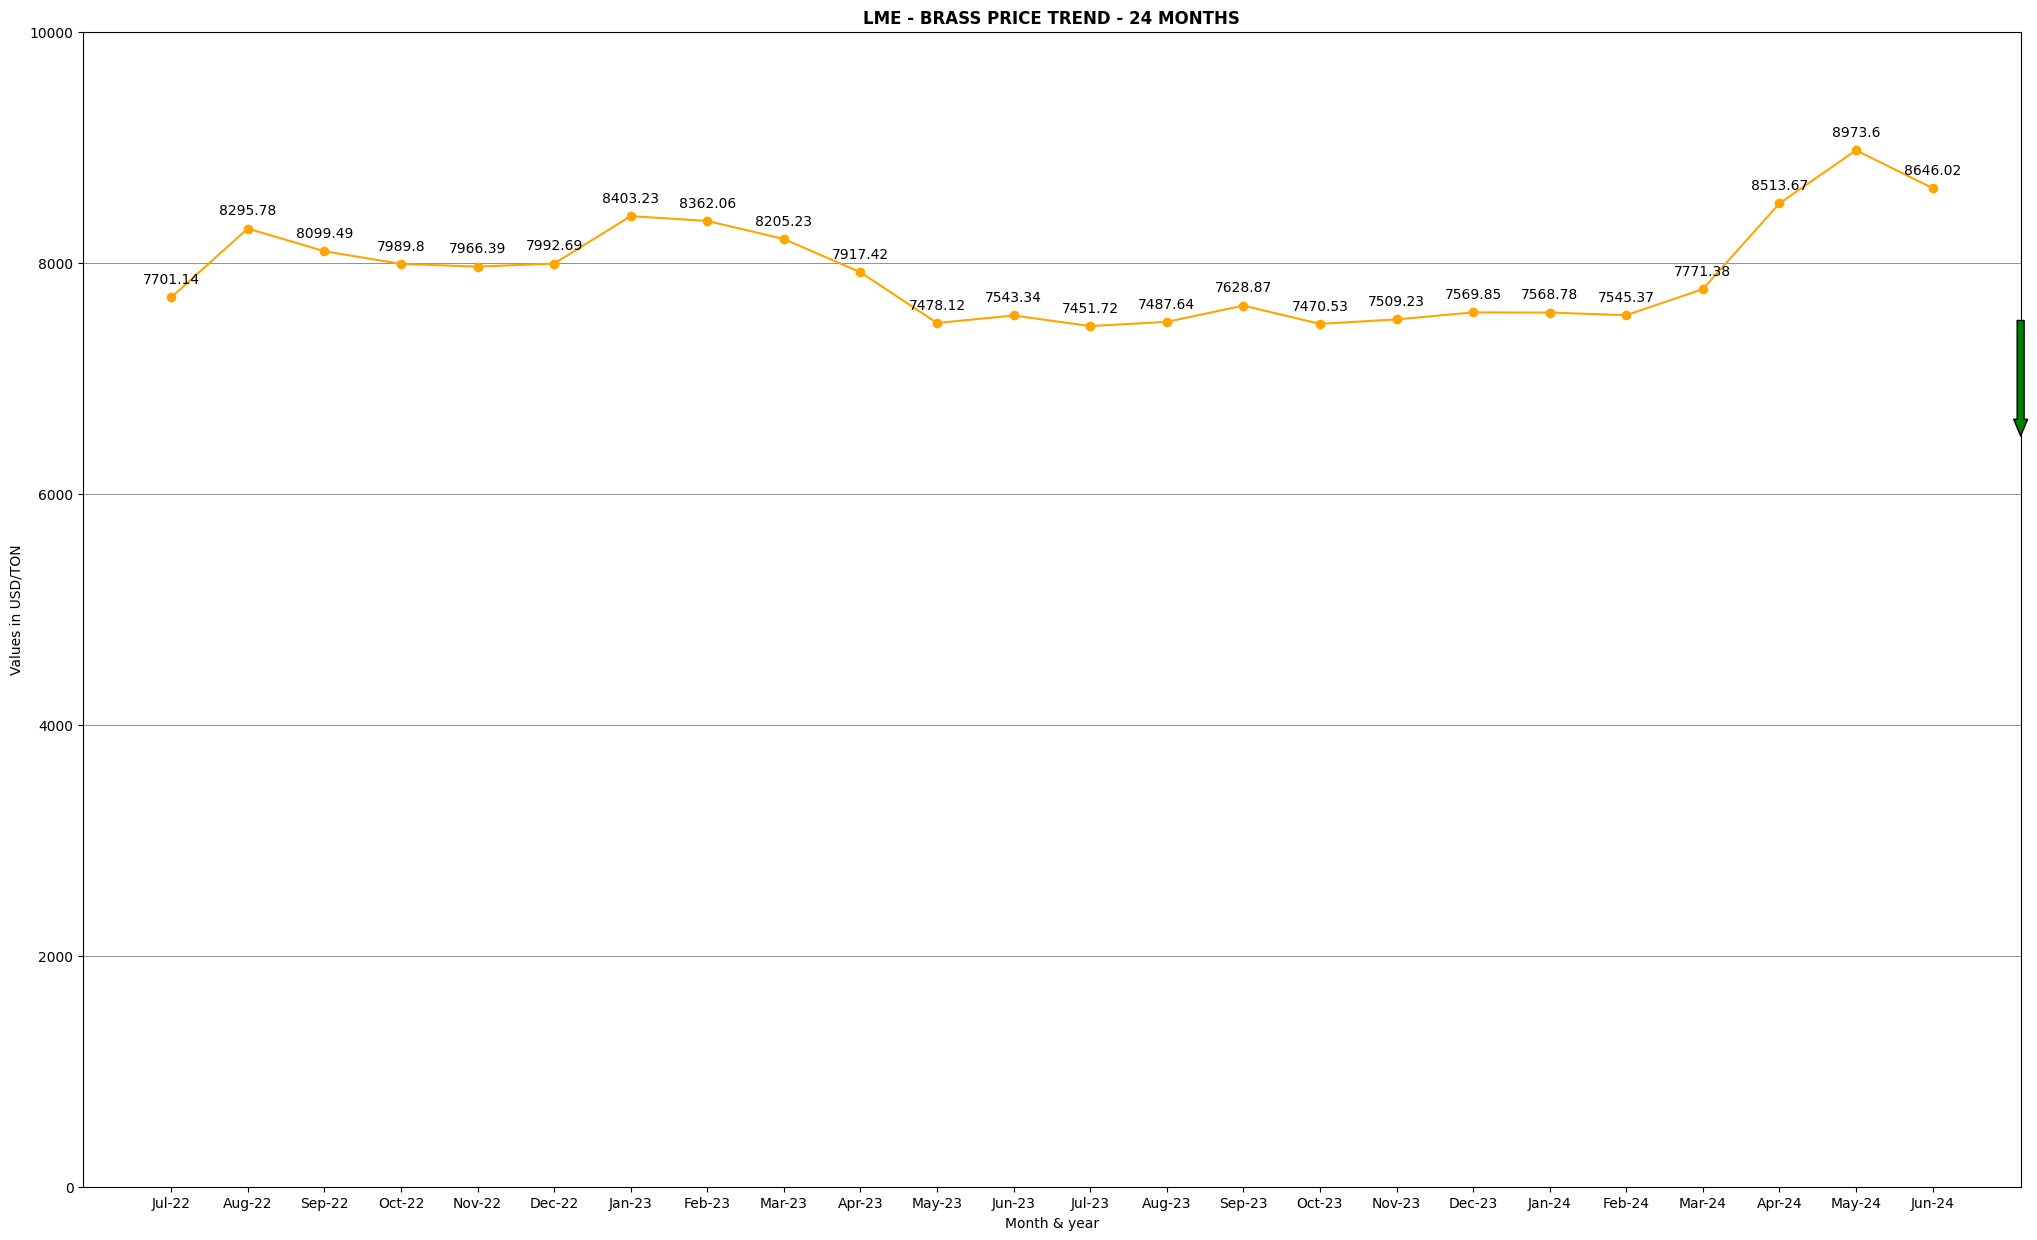

In [ ]:
def task():
  getdet()
  getbrass()
  sendmail()
task()